Deep Reinforcement Learning with TensorFlow
=============

Ron Wu
-------------

11/17/16

Reference:  
David Silver,  http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html<br>
Richard Sutton, Andrew Barto, https://webdocs.cs.ualberta.ca/%7Esutton/book/the-book-2nd.html<br>
Shang Tong Zhang, https://github.com/ShangtongZhang/reinforcement-learning-an-introduction<br>
Denny Britz, https://github.com/dennybritz/reinforcement-learning<br>
John Schulman, Pieter Abbeel, http://rll.berkeley.edu/deeprlcourse/<br>
Charles Isbell, Michael Littman, https://www.udacity.com/course/reinforcement-learning--ud600

### Contents

   1. <a href=#sss>Small Scale States RL</a>
       - <a href =#mdp>Markov Decision Processes</a> 
       - <a href =#free>Model Free</a> 
<br><br> 

<a name='intro'></a>
## Introduction

In the last "Convolutional Neural Networks for Image Processing, Recurrent Neural Networks for Natural Language Processing with TensorFlow" note, I highlighted the triumph of artificial intelligence, AlphaGo (led by David Silver and Demis Hassabis) beat human. AlphaGo used 12 layers of CNN to derive a value network and a policy network from 30,000,000 professional played games as initial training dataset, then it used reinforcement learning to learn optimal policies (strategies). 

Nature, "Mastering the game of Go with deep neural networks and tree search"
http://www.nature.com/nature/journal/v529/n7587/full/nature16961.html or watch this talk https://youtu.be/aiwQsa_7ZIQ?t=300

Reinforcement learning is the main focus of this note. The reason it is called deep reinforcement learning is that both CNN and RNN are big parts of it. CNN is used as external vision and leads to general purpose AI; RNN is used for predicting sequence of hidden states in the Markov decision model.  

Nature, "Human-level control through deep reinforcement learning" http://www.nature.com/nature/journal/v518/n7540/full/nature14236.html

<a name='sss'></a>
# 1. Small Scale States RL

The dimension of states space of AlphaGo is 10^100 and compare this to the size of our universe. There are only 10^82 atoms in the entire universe! So we will need some approximation, sampling techniques to deal with AlphaGo. But before doing that, we will first study RL of small size problems.

<a name ='mdp'></a>
## Markov Decision Processes (MDP)

First watch this video from early 50's by the father of information science, Claude Shannon, a mathematician.

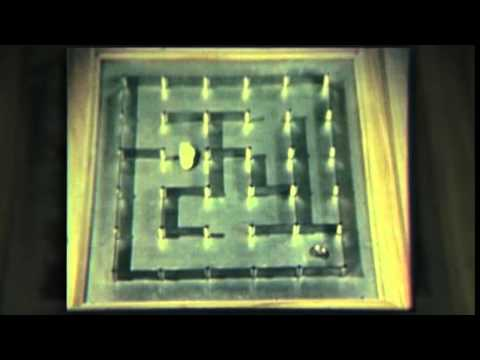

In [11]:
from IPython.display import YouTubeVideo
YouTubeVideo("vPKkXibQXGA", start=8, autoplay=0, theme="light", color="white", height=400, width=500,showinfo=0)

In the video, one can see it used relays as memory storage (store the action) and the algorithm was kind like depth first search. However such approach is hard to generalize. We will solve the same problem using a more general approach.

### Bellman Equation


A policy (decision) function is a map from states to actions

$$\pi: s \rightarrow a, \space \pi= \text{P}(a|s)$$ 

If it is Markov, then the next state is fully determined by the previous state and action. Assuming the states are fully observable, thus 

$$s_{t+1} = f(s_t, a_t)$$ 

For now we assume $f$ is a function (it is not the case for partially obserable MDP. Later when we do model free RL, we don't even have $f$ being distribution.) But notice $\pi$ is almost always not a function. A policy can take multiple (stochastic) actions.

There is also a reward function $$R(s,a)$$ 

It says when the system at state $s$, if it chooses the right action $a$, it will get some reward. Rewards are discounted by $\gamma\in[0,1]$ so that the algorithm will try to reach the maximum reward in shortest steps. Having a $\gamma$ close to 1 allows to explore more pathes, and may endup cumulate more rewards in the long run. Later we will discuss them in detail in Exploration vs Exploitation section.

The total goal now is to
$$\text{max}_{\pi}\big(\mathbb{E}_{\pi}[R(s_0,a_0)]+\gamma \mathbb{E}_{\pi}[R(s_1,a_1)]+\gamma^2\mathbb{E}_{\pi}[R(s_2,a_2)] +...\big)$$


The reason $R$ is surround by $\mathbb{E}_{\pi}$ is because $\pi$ is not a function.

Borrow idea from dynamic programming, let state-value function be

$$V_{\pi}(s_0) = \mathbb{E}_{\pi}[R(s_0,a_0)+\gamma R(s_1,a_1)+\gamma^2R(s_2,a_2)+...]$$

In words, the state-value function is the expected return at state $s_0$.

Then we get Bellman Expectation Equation:

$$V_{\pi}(s) = \mathbb{E}_{\pi}[R(s,\pi(s))]+\gamma V_{\pi}(f(s,\pi(s)))\space\space \forall s$$

Then finding the optimal policy $\pi^*$ becomes

$$\pi^*=\text{arg max}_{\pi}(V_{\pi}(s))\space\space\forall s$$

This is called Bellman Optimality Equation.

The state-value function defined above works very similar to option pricing when the option is exotic and the stopping time is flexible. See for example Xinfeng Zhou, "A practical guide to quantitative finance interview" figure 5.7 on page 125 and figure 5.9 on page 128.


### How to solve them?


Iterative Method:

 - Policy Iteration: pick random policy (i.e. $\pi$ with equal probability to all actions), use policy evaluation (explain below) to get state-value function, then update policy greedily, meaning pick actions (plural, can be more than one, $\pi$ is not a function!) that give the maximal state-value increase. This is because we can pretend each state as the starting state and using the Bellman Optimality Equation above. Then loop over again, hence each loop is a workable policy, and you call the policy evaluation method, which will erase previous state-value function, re-initialize and iterate and make a new state-value function that reflects the new policy. That is why it is called policy iteration, policy is getting better and better, value-state always starts from random. For the mouse problem, as we will see, one iteration is enough. 
 
     - Policy Evaluation (backup evaluation): given a policy, start from some initial state-value function at episode $k=0$, then follow Bellman Expectation Equation to update state-value  function till converges
$$V_{\pi}^{(k+1)}(s) = \mathbb{E}_{\pi}[R(s,\pi(s))]+\gamma V_{\pi}^{(k)}(f(s,\pi(s))) $$ 
How do we know it has converged? Use Cauchy ($\epsilon$-convergence) known as the stopping condition.
         - Synchronous backups: During the update to $k+1$th episode, keep the old $V^{(k)}(s)$. Similar to batch gradient descent. 
         - Asynchronous backups: During the update, use the newest $V(s)$ whenever available, then the direction of sweeping will make a difference. Similar to stochastic gradient descent.
         - On/Off line policy:
 
  
 - Value Iteration: Instead of iteration state-value function to match policy. Now applying the greedy equation: 
$$\pi^*=\text{arg max}_{\pi}(V_{\pi}(s))\space\space\forall s$$ to let policy match state-values. Starting with some random state-values, find the matching policy using greedy equation. Then apply once (known as one-step lookahead)
$$V_{\pi}^{(new)}(s) = \mathbb{E}_{\pi}[R(s,\pi(s))]+\gamma V_{\pi}^{(old)}(f(s,\pi(s))) $$ 
using the new policy. Then threw out the policy, get a new policy from the new state-values. Thus we see that in such fashion, the state-value is being backup updated from states mostly close to the largest rewards states to least close to the rewards states


There is an alternative description. In the literature people sometimes pull out the argument $a$. Define action-value function 

$$Q_{\pi}(s_0, a_0) = R(s_0,a_0)+\mathbb{E}_{\pi}[\gamma R(s_1,a_1)+\gamma^2R(s_2,a_2)+...]$$


In words, the action-value function is the expected return starting at state $s_0$ with action $a_0$.


Then

$$Q_{\pi}(s_0, a_0) = R(s_0,a_0)+ \gamma V_{\pi}(f(s_0, a_0))$$

and

$$V_{\pi}(s_0) = \mathbb{E}_{\pi}[Q_{\pi}(s_0, a_0)]$$

Combining the two above, Bellman Expectation Equation is replaced by 


$$Q_{\pi}(s, a) = R(s,a)+ \gamma \mathbb{E}_{\pi}[Q_{\pi}(f(s,a), \pi(f(s,a))]\space\space\forall s, \forall a$$


Here for notational convenience I make the optimal policy to be a "function" that outputs $a$'s for input $s$. So is below.

Then finding the optimal policy $\pi^*$ becomes

$$\pi^*(s)=\text{arg max}_{a}(Q_{\pi}(s, a))\space\space\forall s$$

which is too called Bellman Optimality Equation.  This description will help us later in Q-learning.


Later we will talk about other methods: Q-learning (model free), Sarsa, Monte Carlo evaluation, temporal-difference learning ($\lambda$ learn).


### Claude Shannon Mouse Problem

Let us now come back to the mouse problem. Actions = {up, down, left, right}, States = {positions on the board}, $f=$ advancing to the next state if there is no wall, stay same place if there is a wall. $R=0$ until it finds the exist. $\gamma=0.5$.




<a name='free'></a>
## Model-Free Prediction

## Model-Free Control

<a name ='lll'></a>
# 2. Large Scale RL

## Value Function Approximation

## Policy Gradient Methods

## Integrating Learning and Planning

## Exploration and Exploitation

##  Case Study: RL in Classic Games